In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
from dask.distributed import Client, progress
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
import matplotlib
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import ImageGrid
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
import cmocean
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=slice(10,50), longitude=slice(220,250))

filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2_vertical_levels/201*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess)
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds = ds.sel(time=slice('2019-03-04-18', '2019-03-06-18'))
ds.p.attrs['units'] = 'mbar'
# ds

## load important variables
omega = ds.omega

da_MSL = ds.PRMSL_meansealevel
da_MSL = da_MSL/100 # convert to hPa

da_CAPE = ds.capesfc
da_CIN = ds.cinsfc

pressure = ds.p

da_V = ds.v
da_U = ds.u
da_TMP = ds.temp
da_RH = ds.rh

ds size in GB 0.13



In [3]:
T = da_TMP - 273.15 ## convert to degree Celsius
RH = da_RH
## Calculate the dewpoint from relative humidity and temperature (deg C)
td = 243.5*(np.log(RH/100)+((17.67*T)/(243.5+T)))/(17.67-np.log(RH/100)-((17.67*T)/(243.5+T)))
td_K = td.values +273.15 * units.degK

tmp2, p = xr.broadcast(da_TMP, pressure)
pres = p * units.hectopascal
pres.attrs['units'] = 'hPa'

## Calc EPT
EPT = mpcalc.equivalent_potential_temperature(pres, da_TMP, td_K)

In [4]:
def interp_lightning(df, latitude_bins, longitude_bins):
    ''' Interpolate lightning point data to frequency per grid cell 
    based on latitude and longitude bins'''
    latitude_group= pd.cut(df['latitude'], bins=latitude_bins)
    longitude_group= pd.cut(df['longitude'], bins=longitude_bins)
    new_df = df.groupby([(latitude_group), (longitude_group)]).sum()
    lightning_count = new_df['freq'].values
    lightning_count = lightning_count.reshape((latitude_bins.size-1, longitude_bins.size-1))
    
    return lightning_count
  

In [5]:
### Lightning Data
filename = '/home/sbarc/students/nash/data/ENTLN/ENTLN_flashes_-_UC_Santa_Barbara_030419_00UTC_to_030819_00UTC_flash_combined.csv'
df = pd.read_csv(filename, header=0, parse_dates=['timestamp'])
df['day'] = df.timestamp.dt.day ## Make a column that shows just the day of the lightning strike
#greater than the start date and smaller than the end date
mask = (df['timestamp'] <= '2019-03-07-00')
df = df.loc[mask]
df['freq'] = df.icmultiplicity + df.cgmultiplicity

latitude_bins = np.arange(10.0, 51., 0.5)
longitude_bins = np.arange(-140.0, -109., 0.5)
lightning_count = []
days_less = ['05', '05', '05', '05', '06', '06', '06', '06', '07']
days_greater = ['04', '05', '05', '05', '05', '06', '06', '06', '06']
hours_less = ['00', '06', '12', '18', '00', '06', '12', '18', '00']
hours_greater = ['18', '00', '06', '12', '18', '00','06', '12', '18']
for i in np.arange(9):
    mask = (df['timestamp'] < '2019-03-{0}-{1}'.format(days_less[i], hours_less[i])) & (df['timestamp'] >= '2019-03-{0}-{1}'.format(days_greater[i], hours_greater[i]))
    new_df = df.loc[mask]
    lightning_count.append(interp_lightning(new_df, latitude_bins, longitude_bins))
lightning_count = np.asarray(lightning_count)

In [6]:
## Put all variables for plotting into xarray
new_ds = xr.Dataset({'RH': (['time', 'lev', 'lat', 'lon'], da_RH),
                    'TEMP': (['time', 'lev', 'lat', 'lon'], da_TMP-273.15),
                    'U': (['time', 'lev', 'lat', 'lon'], da_U),
                    'V': (['time', 'lev', 'lat', 'lon'], da_V),
                    'lightning': (['time', 'lat', 'lon'], lightning_count),
                    'CAPE': (['time', 'lat', 'lon'], da_CAPE),
                    'CIN': (['time', 'lat', 'lon'], da_CIN),
                    'EPT': (['time', 'lev', 'lat', 'lon'], EPT),
                    'Td': (['time', 'lev', 'lat', 'lon'], td)},
                    coords={'lev': (['lev'],pressure),
                        'time': ds.time,
                        'lat': (['lat'], ds['latitude']),
                        'lon': (['lon'], ds['longitude'])})
# new_ds

In [7]:
## Find location and frequency of maximum lightning
## Get CIN and CAPE values at maximum lightning location
da_max_lightning = []
da_max_CAPE = []
da_max_CIN = []
da_max_VVEL = []
for i in np.arange(9):
    CAPE = new_ds.CAPE[i]
    CIN = new_ds.CIN[i]
    da = new_ds.lightning[i]
    da_VVEL = omega[i]
    da_max_lightning.append(da.where(da==da.max(), drop=True).squeeze())
    da_max_VVEL.append(da_VVEL.where(da_VVEL==da_VVEL.min(), drop=True).squeeze())
    da_max_CAPE.append(CAPE.where(da==da.max(), drop=True).squeeze())
    da_max_CIN.append(CIN.where(da==da.max(), drop=True).squeeze())
# print(da_max_lightning)
da_max_lightning[6] = new_ds.lightning.sel(time='2019-03-06 06:00', lat=34., lon=240)

In [8]:
subtitles = ['(a) 4 March 2019 18 UTC', 
             '(b) 5 March 2019 00 UTC', '(c) 5 March 2019 06 UTC', '(d) 5 March 2019 12 UTC',
             '(e) 5 March 2019 18 UTC',
            '(f) 6 March 2019 00 UTC', '(g) 6 March 2019 06 UTC', '(h) 6 March 2019 12 UTC',
             '(i) 6 March 2019 18 UTC']

xlabels = ['', '', '',
           '', '', '',
           'T ($\mathrm{\degree C}$)', 'T ($\mathrm{\degree C}$)', 'T ($\mathrm{\degree C}$)']
xlabels2 = ['', '', '',
           '', '', '',
           '$\mathrm{\Theta_{E} \: (K)}$', '$\mathrm{\Theta_{E} \: (K)}$', '$\mathrm{\Theta_{E} \: (K)}$']


ylabels = ['', '', '',
           'Pressure (hPa)', '', '',
           '', '', '']

bottom_labels = [False, False, False,
                False, False, False, 
                True, True, True]
left_labels = [True, False, False,
              True, False, False,
              True, False, False]

skew_xtick_labels = [u'$\u2212 20$', u'$\u2212 10$', '$\mathrm{0\degree C}$',
                     '$\mathrm{10}$', '$\mathrm{20}$']

ax3_xtick_labels = ['', '312', '', '320',
                     '', '328']

## Colormap information
lightning_cmap = cmocean.cm.dense
lightning_clevs = [1, 5, 10, 20, 40, 60, 80, 100, 150, 200, 300, 400]
lightning_norm = mcolors.BoundaryNorm(lightning_clevs, lightning_cmap.N)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

./figures/fS10.png


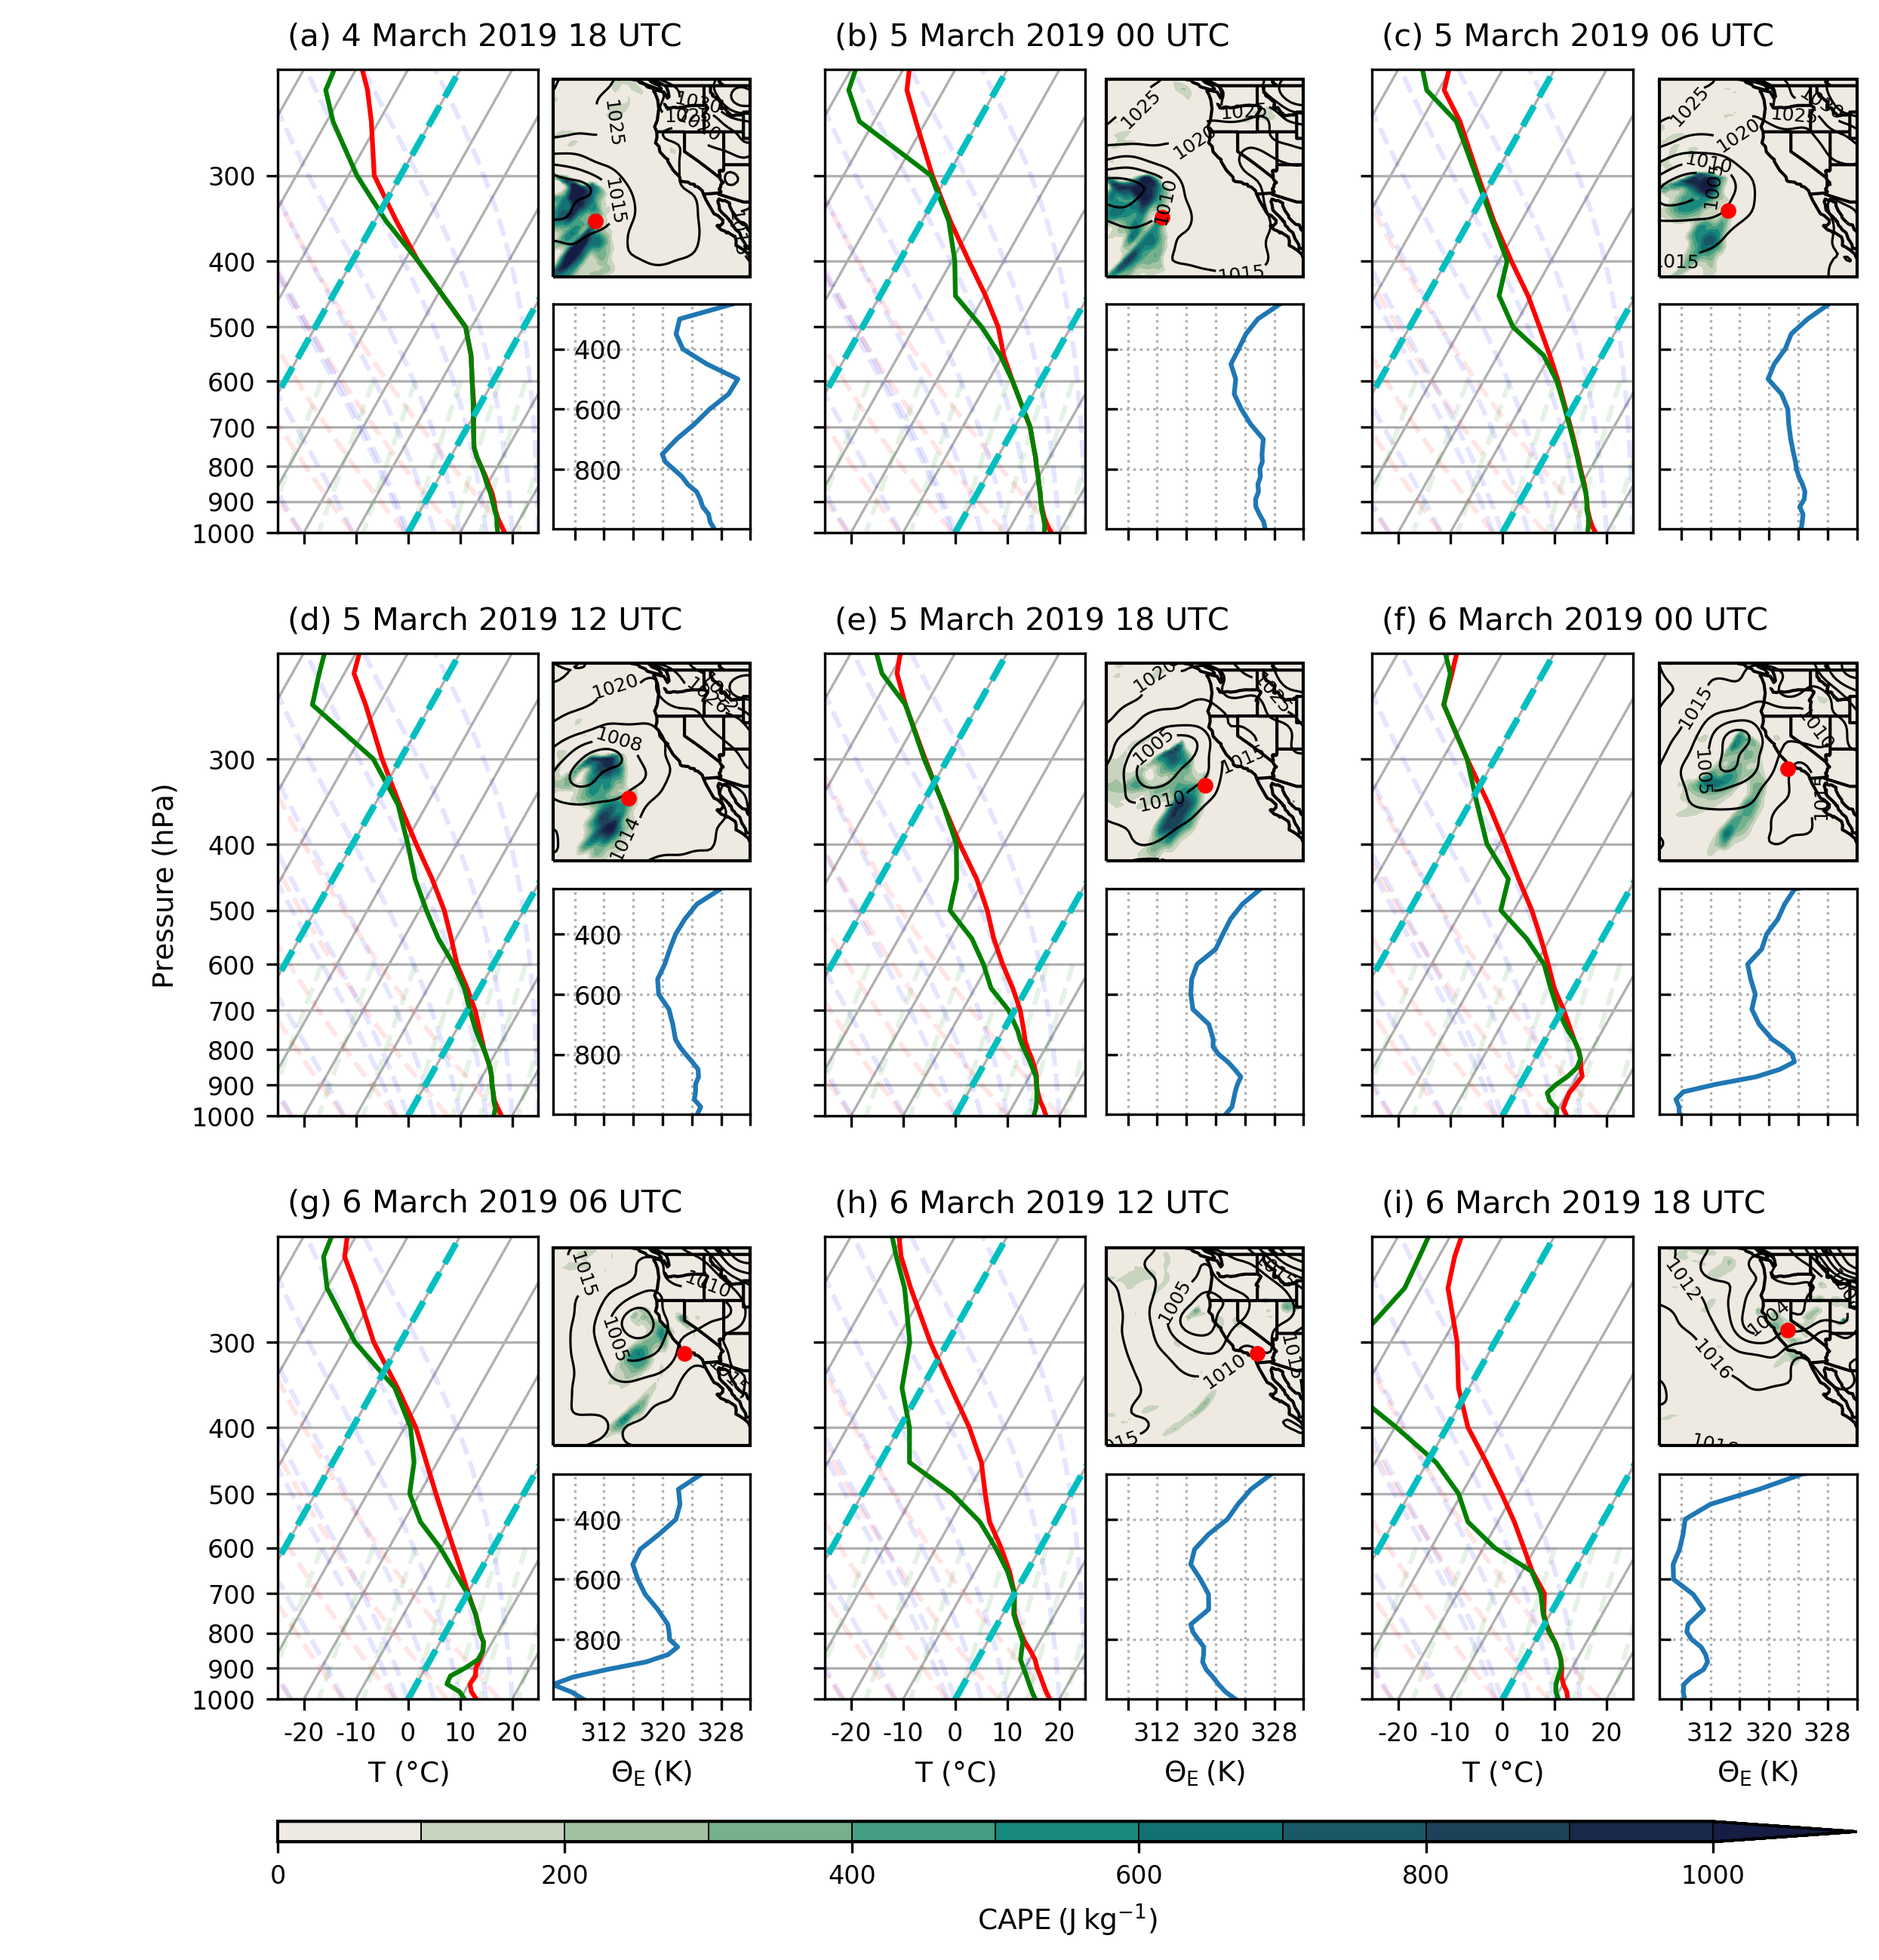

<Figure size 2700x2700 with 0 Axes>

In [9]:
fig = plt.figure(figsize=(9, 9))
fig.dpi = 300
fname = './figures/fS10'
fmt = 'png'
widths = [.5, .5, .5]
heights = [1, 1, 1]
heights2 = [.25, .25, .25]

spec1 = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights, right=0.79,
                          wspace=1.1, hspace=0.26, bottom=0.08)
spec2 = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights2, left=0.26, top=0.765, bottom=0.08,
                         hspace=1.6, wspace=1.8)
spec3 = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights2, left=0.26, bottom=0.2,
                          hspace=1.7, wspace=1.8)
spec4 = fig.add_gridspec(ncols=3, nrows=1, top=0.02, bottom=0.01)


i = 0 ## set counter for plot indexing
for row in range(3):
    for col in range(3):
### Variables for plotting 
        ## make sure variables have correct units attached (for plotting)
        x = da_max_lightning[i].lon.item()
        y = da_max_lightning[i].lat.item()
        p = new_ds.lev.values * units.hPa
        T = new_ds.TEMP[i].sel(lat=y, lon=x).values * units.degC
        u = new_ds.U[i].sel(lat=y, lon=x).values * units.knots
        v = new_ds.V[i].sel(lat=y, lon=x).values *units.knots
        td = new_ds.Td[i].sel(lat=y, lon=x).values * units.degC
        EPT = new_ds.EPT[i].sel(lat=y, lon=x).values
### SkewT - LogP Plots ###
#         ax1 = fig5.add_subplot(spec1[row, col])
        skew = SkewT(fig, rotation=45, subplot=spec1[row, col])
        skew.plot(p, T, 'r', label='Temperature')
        skew.plot(p, td, 'g', label='Dew Point Temperature')
#         skew.plot_barbs(p, u, v)
        skew.ax.set_ylim(1000, 210)

        # Slanted line at constant T -- in this case the 0 and 40 isotherm
        skew.ax.axvline(0, color='c', linestyle='--', linewidth=2, label='0C isotherm')
        skew.ax.axvline(-40, color='c', linestyle='--', linewidth=2, label='-40$\degree$C isotherm')
    
        # Add the relevant special lines
        skew.plot_dry_adiabats(label='Dry Adiabats', alpha=0.1)
        skew.plot_moist_adiabats(label='Moist Adiabats', alpha=0.1)
        skew.plot_mixing_lines(label='Mixing Lines', alpha=0.1)
    
        plt.xlabel(xlabels[i], fontsize=9)
        plt.ylabel(ylabels[i], fontsize=9)
        skew.ax.xaxis.set_tick_params(rotation=0, labelsize=8)
        skew.ax.yaxis.set_tick_params(labelleft=left_labels[i], labelsize=8) 
        skew.ax.xaxis.set_tick_params(labelbottom=bottom_labels[i])
        ## Add *C to xticklabels
#         skew.ax.set_xticks(np.arange(-20, 30, 10))
#         skew.ax.set_xticklabels(skew_xtick_labels)
        
        skew.ax.set_xlim(-25, 25)
        plt.annotate(subtitles[i], (3, 155), xycoords='axes points', fontsize=10.)
        
### Lightning Maps ###
        ax2 = fig.add_subplot(spec3[row, col], projection=ccrs.PlateCarree())
        results = new_ds.CAPE[i]
        clevs = np.arange(-4.0, 0.1, 0.1)
        ax2.set_extent([-140., -110., 20., 50.], crs=ccrs.PlateCarree())
        capeclevs = np.arange(0,1100,100)
        cape_cmap = cmocean.cm.tempo
        cf = ax2.contourf(new_ds.lon, new_ds.lat, results, transform=ccrs.PlateCarree(),
                            extend='max', cmap=cape_cmap, levels=capeclevs)
        contour_MSL = ax2.contour(new_ds.lon, new_ds.lat, da_MSL[i], transform=ccrs.PlateCarree(),
                                    colors='black', linewidths=0.75)
    
        plt.clabel(contour_MSL, inline=1, fontsize=6, fmt="%i")

        # Add Border Features
        ax2.coastlines(linewidths=1.0)
        ax2.add_feature(states_provinces, edgecolor='k')
        ax2.add_feature(cfeature.BORDERS)
        ## Add a marker at highest lightning frequency
        ax2.plot(da_max_lightning[i].lon.item(), da_max_lightning[i].lat.item(),
                 'ro', markersize=4, transform=ccrs.PlateCarree())

        ## Add colorbar
        cax = fig.add_subplot(spec4[:, :])
        cbar = fig.colorbar(cf, cax=cax, drawedges=True, 
                        orientation='horizontal', extendfrac='auto', shrink=0.8)
        cbar.set_label(r'$\mathrm{CAPE \:(J\:kg^{-1})}$', fontsize=9)
        cbar.ax.tick_params(labelsize=8)
        

### EPT Plots ###
        ax3 = fig.add_subplot(spec2[row, col])
        plt.plot(EPT, p)
        plt.gca().invert_yaxis()
        ax3.set_ylim(999, 250)
        ax3.tick_params(axis="y",direction="in", pad=-22)
        ax3.grid(linestyle=':')
        ax3.yaxis.set_tick_params(labelleft=left_labels[i], labelsize=8) 
        plt.xlabel(xlabels2[i], fontsize=9)
        plt.ylabel('', fontsize=12)
        ax3.xaxis.set_tick_params(rotation=0, labelsize=8, labelbottom=bottom_labels[i])
        ## Add K to xticklabels
        ax3.set_xticks(np.arange(308, 334, 4))
        ax3.set_xticklabels(ax3_xtick_labels)
        ax3.set_xlim(305, 332)
                                    
        i = i+1 #add one to the counter to plot next


# save and show the plot
fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))